# Course Project

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- 1 - The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- 2 - Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- 3 - Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?

## 1 - Dataset exploration

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [1]:
import urllib
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


## Load data and clean it up

__Load the data__

hint: data is in csv format; pandas is a python library that can read csv files

you can choose to represent your data either as a DataFrame or as a dictionary

- The dataset contains data on how many convicts? 
<span style="color:green">7214 convicts</span>

- What are the features the dataset contains?
<span style="color:green">
    ['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1','start', 'end', 'event', 
    'two_year_recid']
</span>

hint pandas: check pandas functions shape, column, head

hint dictionary: check keys() function

__Cleanup the data__

- Are there missing values (NaN)? are there outliers?  
<span style="color:green">Yes there are missing values and outliers.</span>

hint pandas: check isnull function in pandas

hint dictionary: implement a for and check if the variable is None

- Does ProPublica mentions how to clean the data?  
<span style="color:green">Yes</span>

__What is the effect of the following function?__

In [2]:
df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape) # (Rows, Cols)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

(7214, 53)


In [3]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6168,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
6169,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
6170,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Basic analysis of demographics

- What are the different races present in the dataset? 
<span style="color:green"> When we ran <b>df.drop_duplicates(subset=['race'])</b>, we obtained 6 rows of different races which are: [Other, African-American, Caucasian, Hispanic, Asian, Native American] </span>
- What is the number of people by age category?
<span style="color:green">When we ran <b>df['age_cat'].value_counts()</b>, we obtained the following result:
<ul style="color:green">
    <li>25 - 45 : 3532</li>
    <li>Less than 25 : 1347</li>
    <li>Greater than 45 : 1293</li>
</ul>
</span>
- What is the number of people by race?
<span style="color:green">When we ran <b>df['race'].value_counts()</b>, we obtained the following result:
<ul style="color:green">
    <li>African-American : 3175</li>
    <li>Caucasian : 2103</li>
    <li>Hispanic : 509</li>
    <li>Other : 343</li>
    <li>Asian : 31</li>
    <li>Native American : 11</li>
</ul>
</span>
- What is the number of people by COMPAS score (decile_score)?
<span style="color:green">When we ran <b>df['decile_score'].value_counts()</b>, we obtained the following result:
<ul style="color:green">
    <li>1 : 1286</li>
    <li>2 : 822</li>
    <li>4 : 666</li>
    <li>3 : 647</li>
    <li>5 : 582</li>
    <li>6 : 529</li>
    <li>7 : 496</li>
    <li>9 : 420</li>
    <li>8 : 420</li>
    <li>10 : 304</li>
</ul>
</span>
- What is the number of people by COMPAS risk category (score_text)?
<span style="color:green">When we ran <b>df['score_text'].value_counts()</b>, we obtained the following result:
<ul style="color:green">
    <li>Low       3421</li>
    <li>Medium    1607</li>
    <li>High      1144</li>
</ul>
</span>

## Basic investigations of gender and race bias in COMPAS scores

decile_score -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

score_text -- is the level of risk: Low, Medium, High

two_years_recid -- is the ground truth data on whether the offender recidivated or not

- What is the mean COMPAS score (decile_score) per race and gender?
<span style="color:green">When we run <b>df.groupby(["race", "sex"], as_index=False)['decile_score'].mean()</b> we get the following:</span>

In [4]:
df.groupby(["race", "sex"], as_index=False)['decile_score'].mean()
# Where we express the decile_score mean for each races' two gender types (Female, Male)

,race,sex,decile_score
0,African-American,Female,4.639344
1,African-American,Male,5.410129
2,Asian,Female,2.000000
3,Asian,Male,2.896552
4,Caucasian,Female,3.792531
5,Caucasian,Male,3.588526
6,Hispanic,Female,2.682927
7,Hispanic,Male,3.517564
8,Native American,Female,8.500000
9,Native American,Male,6.000000


- What is the distribution (histogram) of decile_score per race and gender? 

<AxesSubplot:>

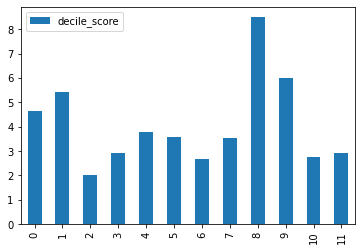

In [5]:
df.groupby(["race", "sex"], as_index=False)['decile_score'].mean().plot.bar(y='decile_score')

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested? 
<span style="color:green">When we ran <b>df['two_year_recid'].value_counts()</b>, we found that 2809 people were re-arrested, and 3363 were not.</span>
- Compute the recidivism (i.e., people that got re-arrested) rates by race and gender
<span style="color:green">When we ran <b>df[(df.two_year_recid == 1)].groupby(["race", "sex"], as_index=False)['two_year_recid'].count()</b>, we got the following results:
</span>

In [6]:
df[(df.two_year_recid == 1)].groupby(["race", "sex"], as_index=False)['two_year_recid'].count()
# This table represents the recidivism rates by race and gender

,race,sex,two_year_recid
0,African-American,Female,203
1,African-American,Male,1458
2,Asian,Female,1
3,Asian,Male,7
4,Caucasian,Female,170
5,Caucasian,Male,652
6,Hispanic,Female,26
7,Hispanic,Male,163
8,Native American,Female,2
9,Native American,Male,3


- What is the accuracy of the COMPAS scores to predict recidivism

In [7]:
from sklearn.metrics import accuracy_score

y_pred = np.round(df["decile_score"]/df["decile_score"].max())
y_true = df["two_year_recid"]

print("Accuracy : " + str(accuracy_score(y_true, y_pred)))

Accuracy : 0.6642903434867142


- Is the accuracy higher/lower if we look at particular races/genders? <span style="color:green">It depends on the race, check results below:</span>

In [8]:
# y_pred_1 = df[(df.decile_score == 1)].groupby(["race", "sex"], as_index=False)['decile_score'].count()['decile_score']
# y_true_1 = df[(df.two_year_recid == 1)].groupby(["race", "sex"], as_index=False)['two_year_recid'].count()['two_year_recid']

# print("Accuracy : " + str(accuracy_score(y_true_1, y_pred_1)))

# race
race_le = preprocessing.LabelEncoder()
race_le.fit(df.race)

for i in race_le.classes_:
    race_prob = (df[df['race']== str(i)].decile_score)/10
    race_pred = np.round(race_prob)
    race_true = df[df['race']==i].two_year_recid
    acc = accuracy_score(race_true, race_pred)
    print("Accuracy for '" +str(i)+ "' race: " + str(acc))
    

Accuracy for 'African-American' race: 0.6513385826771654
Accuracy for 'Asian' race: 0.8064516129032258
Accuracy for 'Caucasian' race: 0.6804564907275321
Accuracy for 'Hispanic' race: 0.6601178781925344
Accuracy for 'Native American' race: 0.7272727272727273
Accuracy for 'Other' race: 0.6763848396501457


- What about false positives and false negatives?
<span style="color:green">
    <ul style="color:green">
        <li>False positive rate: 32.35</li>
        <li>False negative rate: 37.40</li>
    </ul>
We obtained these values by running the below:</span>

In [9]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [10]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [11]:
score_text = df['score_text'].to_numpy()
y_old_pred = np.ravel([int(s=="Medium" or s=="High") for s in score_text])

y = df['two_year_recid'].to_numpy()

In [12]:
del df['two_year_recid']
del df['score_text']

In [13]:
# Let's remove the unnecessary attributes
del df['name']
del df['first']
del df['last']
del df['compas_screening_date']
del df['dob']

In [14]:
sex = df['sex'].to_numpy()
sex = np.ravel([int(s=="Male") for s in sex])

df['sex'] = sex

In [15]:
from sklearn import preprocessing

# age_cat
le = preprocessing.LabelEncoder()
le.fit(df.age_cat)
df['age_cat'] = le.transform(df.age_cat)

# race
df['race'] = race_le.transform(df.race)

# vr_charge_degree
le = preprocessing.LabelEncoder()
le.fit(df.vr_charge_degree)
df['vr_charge_degree'] = le.transform(df.vr_charge_degree)

In [16]:
# Cleaning the data

del df['id']
del df['c_jail_in']
del df['c_jail_out']
del df['c_case_number']
del df['c_offense_date']
del df['c_arrest_date']
del df['c_days_from_compas']
del df['r_case_number']
del df['r_days_from_arrest']
del df['r_offense_date']
del df['r_jail_in']
del df['r_jail_out']
del df['vr_offense_date']
del df['screening_date']
del df['v_score_text']
del df['v_screening_date']
del df['in_custody']
del df['out_custody']
del df['is_recid']
del df['age']
del df['decile_score']
del df['start']
del df['end']
del df['event']
del df['days_b_screening_arrest']
del df['c_charge_desc']
del df['r_charge_degree']
del df['r_charge_desc']
del df['violent_recid']
del df['is_violent_recid']
del df['vr_case_number']
del df['decile_score.1']
del df['v_type_of_assessment']
del df['v_decile_score']
del df['priors_count.1']
del df['c_charge_degree']
del df['vr_charge_desc']
del df['type_of_assessment']
del df['juv_fel_count']
del df['juv_misd_count']
del df['juv_other_count']

In [17]:
df_african_american = df['race'].mask(df['race']==0,1).mask(df['race']!=0,0)
df_Asian = df['race'].mask(df['race']==1,1).mask(df['race']!=1,0)
df_Caucasian = df['race'].mask(df['race']==2,1).mask(df['race']!=2,0)
df_Hispanic = df['race'].mask(df['race']==3,1).mask(df['race']!=3,0)
df_NativeAmerican = df['race'].mask(df['race']==4,1).mask(df['race']!=4,0)
df_Other = df['race'].mask(df['race']==5,1).mask(df['race']!=5,0)

del df['race']

# adding each race to a new column
df['African-American'] = df_african_american.values
df['Asian'] = df_Asian.values
df['Caucasian'] = df_Caucasian.values
df['Hispanic'] = df_Hispanic.values
df['Native American'] = df_NativeAmerican.values
df['Other'] = df_Other.values

In [18]:
from sklearn.model_selection import train_test_split

X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

## 2 - Standard classifiers 

Different types of classifiers:
<ol>
    <li>Perceptron</li>
    <li>Naive Bayes</li>
    <li>Decision Tree</li>
    <li>K-Nearest Neighbor</li>
    <li>Support Vector Machine</li>
<ol>

### 1 - Perceptron
A Perceptron is an algorithm for supervised learning of binary classifiers. This algorithm enables neurons to learn and processes elements in the training set one at a time.

In [19]:
from sklearn.linear_model import Perceptron

clf = Perceptron()

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6032388663967612

### 2 - Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb.score(X_test, y_test)

0.6842105263157895

### 3 - Decision Tree

In [21]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6898785425101215

### 4 - K-Nearest Neighbor

In [22]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train, y_train)

neigh.score(X_test, y_test)

0.6704453441295547

### 5 - Support Vector Machine

In [23]:
from sklearn import svm

clf = svm.SVC()

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6931174089068826

## 3 - Fair classifiers

<span style="color:green">Logistic Regression: the best classifier, has the best results</span>

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs", penalty = 'l2',fit_intercept=True, max_iter = 100000)

clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6931174089068826

In [25]:
used_descriptors = clf.coef_

count = 0
for i in used_descriptors[0]:
    if i>0:
        count+=1

print("The model uses",count,"descriptors")

The model uses 7 descriptors


In [26]:
print('%.3f' % clf.intercept_, '(Intercept)') 
for i,j in zip(X_train, clf.coef_[0]):
    print('%.3f' % j, i)

4.419 (Intercept)
0.301 sex
0.262 age_cat
0.153 priors_count
-0.654 vr_charge_degree
0.317 African-American
-0.576 Asian
0.075 Caucasian
0.010 Hispanic
0.355 Native American
-0.177 Other


In [27]:
for i,j in zip(X_train, clf.coef_[0]):
    if i in race_le.classes_:
        control = np.exp(clf.intercept_) / (1 + np.exp(clf.intercept_))
        i_odds = np.exp(j) / (1 - control + (control * np.exp(j)))
        print(i + ' defendants: %.4f' % i_odds)

African-American defendants: 1.0032
Asian defendants: 0.9908
Caucasian defendants: 1.0009
Hispanic defendants: 1.0001
Native American defendants: 1.0036
Other defendants: 0.9977


## Let's compare these results to the results obtained by the racially biased COMPAS:

![title](img/coef_racial_bias.jpg)

<span style="color:red"> image source: Compas Analysis.ipynb</span>

In [28]:
compas_list = ['African-American', 'Asian', 'Hispanic', 'Native American', 'Other']
compas_results = [0.477, -0.254, -0.428, 1.394, -0.826]

for i in range(len(compas_list)):
    control = np.exp(-1.525) / (1 + np.exp(-1.525))
    i_odds = np.exp(compas_results[i]) / (1 - control + (control * np.exp(compas_results[i])))
    print(compas_list[i] + ' defendants: %.4f' % i_odds)

African-American defendants: 1.4526
Asian defendants: 0.8081
Hispanic defendants: 0.6951
Native American defendants: 2.6146
Other defendants: 0.4867


<span style="color:green">Let's compare: </span>

<table>
<thead>
  <tr>
    <th></th>
    <th>COMPAS</th>
    <th>Our Fair Classifier</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>African American</td>
    <td>1.4526</td>
    <td>1.0032</td>
  </tr>
   <tr>
    <td>Caucasian</td>
    <td>-</td>
    <td>1.0009</td>
  </tr>
  <tr>
    <td>Asian</td>
    <td>0.8081</td>
    <td>0.9908</td>
  </tr>
  <tr>
    <td>Hispanic</td>
    <td>0.6951</td>
    <td>1.0001</td>
  </tr>
  <tr>
    <td>Native American</td>
    <td>2.6146</td>
    <td>1.0036</td>
  </tr>
  <tr>
    <td>Other</td>
    <td>0.4867</td>
    <td>0.9977</td>
  </tr>
</tbody>
</table>

<span style="color:green"> No race is more likely than another race to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior. Our classifier has proven itself to be a fair classifier amongst all races.</span>